# Nathan Robino

This notebook contains Nathan Robino's answers to problem set 5 in Choice-2025.

In [29]:
# Preamble: import the packages we will be using

# Usual packages
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from dolo import *
import dolo.algos.perfect_foresight as pf
import pandas as pd
import warnings

# Import the Qmod python code from external file

# Since the Qmod class is in other folder we need to
# change the path.
import sys
sys.path.append('../')
from Qmod import Qmod

warnings.filterwarnings('ignore')

Here are a handful of functions to create the figures for each counterfactual.

In [30]:
def phase_diagrams(mod1,mod2,k_min,k_max,npoints = 300):
    """
    Draws the phase diagram of the Qmodel under two different sets of
    parameter values in the same figure, and returns it.

    Parameters:
        - mod1          : Qmod object representing the first set of parameter values.
        - mod1          : Qmod object representing the second set of parameter values.
        - [k_min,k_max] : limits for the value of capital in the phase diagrams.
        - npoints       : number of points in the capital grid to be used for phase
                          diagram plots.
    """

    # Create a figure
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()

    # Plot the loci of the pre and post-change models.
    k_range = np.linspace(k_min,k_max,npoints)
    mods = [mod1,mod2]
    colors = ['r','b']
    labels = ['Mod. 1','Mod. 2']
    for i in range(2):

        ## Lambda Plot ##
        # Plot k0 locus
        ax[0].plot(k_range,mods[i].P*np.ones(npoints),
                 linestyle = '--', color = colors[i],label = labels[i] + ' loci')
        # Plot lambda0 locus
        ax[0].plot(k_range,[mods[i].lambda0locus(x) for x in k_range],
                 linestyle = '--', color = colors[i])
        # Plot steady state
        ax[0].plot(mods[i].kss,mods[i].P,marker = '*', color = colors[i])
        
        # Plot stable arm
        stab_arm = [mods[i].findLambda(k0 = x, k1 = mods[i].k1Func(x)) for x in k_range]
        ax[0].plot(k_range, stab_arm, linestyle = '-', color = colors[i], label = labels[i] + ' stable arm.')

        ## q plot ##
        # Plot k0 locus
        ax[1].plot(k_range,np.ones(npoints),
                 linestyle = '--', color = colors[i],label = labels[i] + ' loci')
        # Plot q0 locus
        ax[1].plot(k_range,[mods[i].lambda0locus(x)/mods[i].P for x in k_range],
                 linestyle = '--', color = colors[i])
        # Plot steady state
        ax[1].plot(mods[i].kss,1,marker = '*', color = colors[i])
        
        # Plot stable arm
        stab_arm = [mods[i].findLambda(k0 = x, k1 = mods[i].k1Func(x))/mods[i].P for x in k_range]
        ax[1].plot(k_range, stab_arm, linestyle = '-', color = colors[i], label = labels[i] + ' stable arm.')

    return(ax)

def impules_responses(mod1, responses, ExogPaths):

    fig, ax = plt.subplots(3,2)
    # New figure for capital dynamics
    ax[0,0].plot(responses.k,'.')
    ax[0,0].set_ylabel('$k$')
    ax[0,0].set_xlabel('Time')

    ax[0,1].plot(responses.i,'.')
    ax[0,1].set_ylabel('$i$')
    ax[0,1].set_xlabel('Time')

    ax[1,0].plot(responses.q_1,'.')
    ax[1,0].set_ylabel('$q$')
    ax[1,0].set_xlabel('Time')

    ax[1,1].plot(responses.lambda_1,'.')
    ax[1,1].set_ylabel('$\\lambda$')
    ax[1,1].set_xlabel('Time')

    # Tax Revenue
    t = (mod1.psi* responses.k ** mod1.alpha)*ExogPaths.tau
    ttotal = np.sum(t)
    ax[2,0].plot(t,'.')
    ax[2,0].set_ylabel('Corporate Tax Revenue')
    ax[2,0].set_xlabel('Time \nTotal Revenue = ' + str(np.round(ttotal,2)))

    # ITC spending
    g = responses.i*ExogPaths.itc_1
    gtotal = np.sum(g)
    ax[2,1].plot(g,'.')
    ax[2,1].set_ylabel('ITC Spending')
    ax[2,1].set_xlabel('Time \nTotal Spending = ' + str(np.round(gtotal,2)))
    fig.tight_layout()
    

    return(ax)

def dolo_responses(seq,shockvar,model,ExogPaths,T,kss):
    ExogTemp = deepcopy(ExogPaths)
    ExogTemp[shockvar] = seq
    response = pf.deterministic_solve(model = model, # Model we are using (in dolo)
                                      shocks = ExogTemp, # Paths for exog. variables 
                                      T=T,           # Total simulation time
                                      s1 = kss,     # Initial state
                                      verbose=False)
    response = response[1:]
    return(response)

def make_diagrams(mod1, mod2, responses, ExogPaths, k_min, k_max) :

    ax = phase_diagrams(mod1, mod2, k_min, k_max)
    # Now we can add the behavior of lambda and k to the diagram.
    ax[0].plot(responses.k, responses.lambda_1, '.k',label = 'Opt. Response')
    ax[1].plot(responses.k, responses.q_1, '.k',label = 'Opt. Response')
    plt.legend()
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('$\\lambda$')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('$q$')

    ax2 = impules_responses(mod1, responses, ExogPaths)

def new_ss(Qmodel,newVarname,newValue):
    # Copy the initial model, change a value and re-solve
    newModel = deepcopy(Qmodel)

    if newVarname == 'R':
        newModel.R = newValue
    if newVarname == 'tau':
        newModel.tau = newValue
    if newVarname == 'itc_1':
        newModel.zeta = newValue
    if newVarname == 'psi':
        newModel.psi = newValue

    newModel.solve()
    return(newModel)

def run_counterfactual(shockSeq,shockVar,shockValue,QDolo,ExogPaths,T,BaseModel):
    response = dolo_responses(shockSeq,shockVar,QDolo,ExogPaths,T,[BaseModel.kss])
    Qnew = new_ss(BaseModel,shockVar,shockValue)
    make_diagrams(mod1 = BaseModel, mod2 = Qnew, responses = response, ExogPaths = ExogPaths, k_min = 2, k_max = 8)

# Baseline model parametrization

In [31]:
# Base parameters

# Discount factor and return factor
beta = 0.98
R = 1/beta

# Tax rate
tau = 0.2

# Share of capital in production
alpha = 0.33

# Adjustment costs
omega = 1
omegaHigh = 3

# Investment tax credit
zeta = 0.2

# Depreciation rate
delta = 0.1

# Technological factor
psi = 1

In [ ]:
# Create the object.
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
# Solve to find the steady state and policy rule.
Qmodel.solve()

# High Adjustment Costs case
QmodelH = Qmod(beta, tau, alpha, omegaHigh, zeta, delta, psi)
# Solve to find the steady state and policy rule.
QmodelH.solve()

## Now configure Dolo Simulations

## Default Parameters
QDolo = yaml_import("../Dolo/Q-model.yaml")
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)

## High Adjustment Costs
QDoloH = yaml_import("../Dolo/Q-model.yaml")
QDoloH.set_calibration(alpha = alpha, delta = delta, omega = omegaHigh)

# Total simulation time
T = 30

# Baseline paths for exogenous variables (which we'll apply shocks to)
Exog = pd.DataFrame({'R':[R]*T,
                     'tau':[tau]*T,
                     'itc_1':[zeta]*T,
                     'psi':[psi]*T})

# Problem 1: Permanent Corporate Tax Rate Increase

1. Leading up to date t, the economy is in steady state. At date t, the government unexpectedly introduces a permanent increase in the corporate tax rate, τ ↑. Show
the effects on a phase diagram and show dynamics of investment, capital, share prices, and q following the tax change. In particular explain what, if anything,
happens to λ, the share price of the firm, when the τ is implemented.

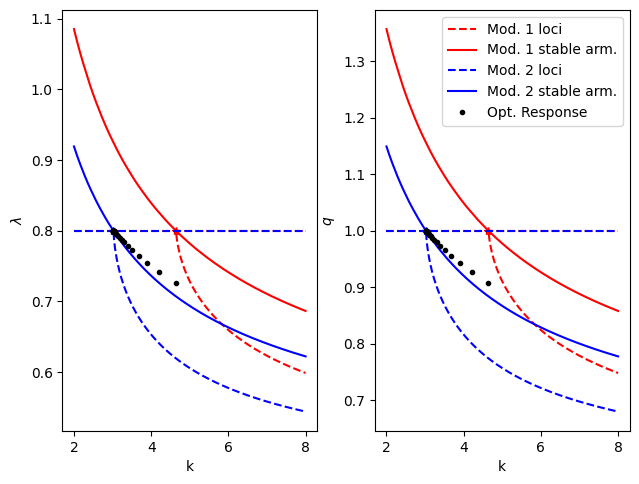

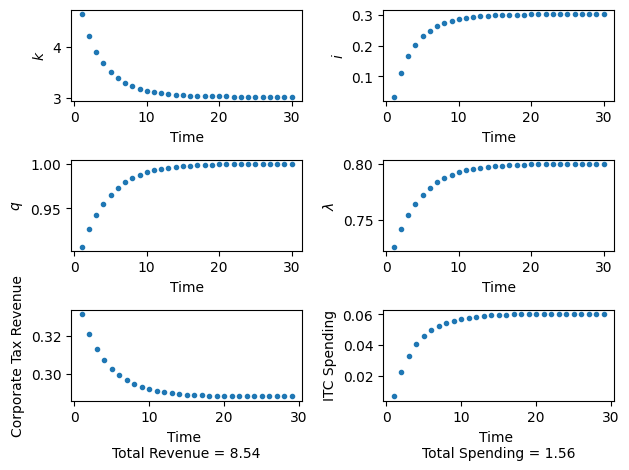

In [34]:
# Here a permanent shock to the corporate tax rate (tau) occurs in period 0
shockVar = 'tau'; shockValue   = 0.4; shockSeq = np.array([shockValue]*(T))    

# Create phase diagrams and impulse responses
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDolo,ExogPaths=Exog,T=T,BaseModel=Qmodel)

##  New Steady State
In this scenario, the $ITC_t$ is unchanged, so the dynamics of $q$ are given by

$𝔼_t[\Delta ϙ_{t+1}] ≈ (r + δ)ϙ_t - [(1-\tau)f^k_t(k_t) - j^k_tβ]$,

and the $𝔼_t[\Delta ϙ_{t+1}] = 0$ locus is $ϙ_t = [(1-\tau)f^k_t(k_t) - j^k_t\beta]/(r + \delta)$.

Since $f^k_t(k_t) > 0$ for any level of $k_t$, when the corporate tax rate $\tau$ increases, $ϙ_t$ must be lower. Thus the locus $𝔼_t[\Delta ϙ_{t+1}] = 0$ shifts down.

The $\Delta k_{t+1} = 0$ locus is unaffected, since $\delta$ and  $𝒫_t$ are unchanged. Therefore in the new steady state, $k_t$ decreases,$ϙ_t$ returns to its equilibrium value of 1, and since $𝒫_t$ is unchanged, $\lambda$ also returns to its original value before the tax change.

## Dynamics
On impact, the after tax marginal product of capital $(1-\tau)f^k_t(k_t)$ drops discontinuously, leading to a situation with $𝔼_t[\Delta ϙ_{t+1}] > 0$. Then the value of a unit of capital inside the firm is less valuable than  outside the firm, i.e., the firm is too large. Thus net investment will decrease so that the firm's capital stock decreases over time. The largest adjustments happen immediately, since firms want to minimize the adjustment costs $j^k_t$, which will decrease as the firm shrinks. Then as $k_t$ decreases, $(1-\tau)f^k_t(k_t)$ increases, so $ϙ_t$ and therefore $\lambda_t$ recover to their original steady state.

# Problem 2: Temporary Corporate Tax Rate Increase

2. Leading up to date t, the economy is in steady state. At date t, the government unexpectedly introduces a temporary increase in the corporate tax rate, τ ↑. The
high τ will last for two years, and then the τ will revert back to its normal level. Show the effects on a phase diagram and show dynamics of investment, capital, share prices, and q, and the capital stock under two scenarios: (1) costs of adjustment for the capital stock, ω, are high; (2) costs of adjustment are low. EXPLAIN your results.


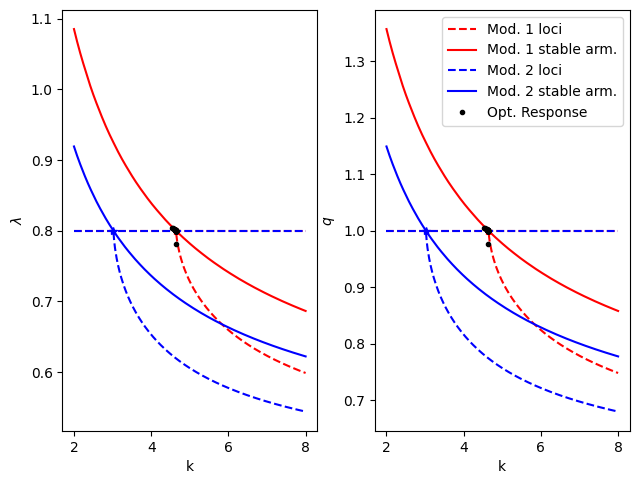

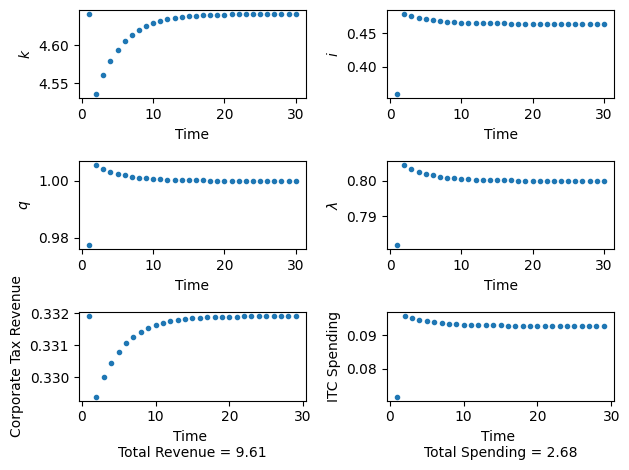

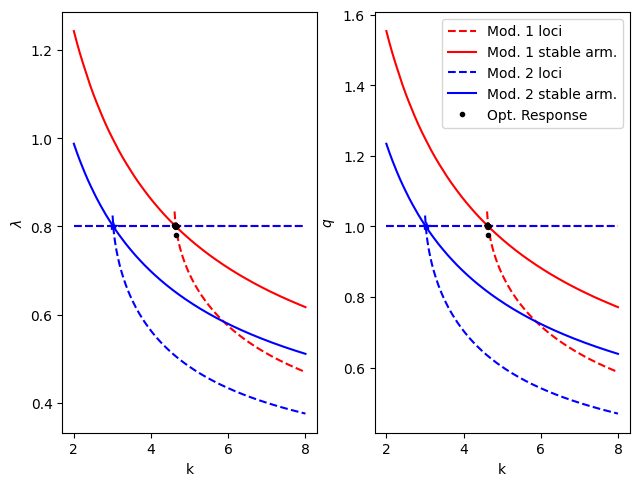

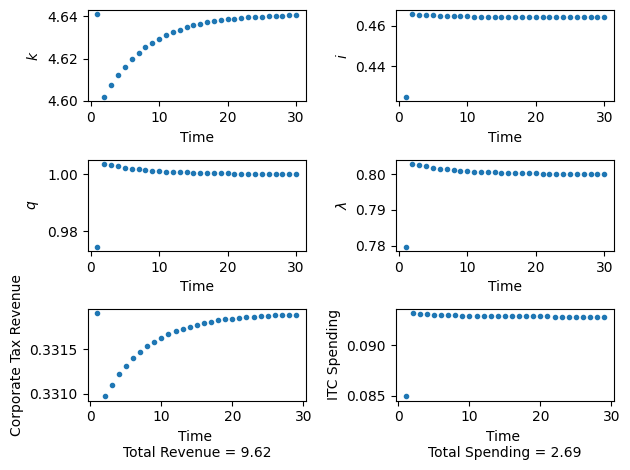

In [40]:
# Here a 2 year shock to the corporate tax rate (tau) occurs in period 0
shockVar = 'tau'; shockValue   = 0.4; shockSeq = np.array([shockValue]*2 + [tau]*(T-2)) 

# Create phase diagrams and impulse responses
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDolo,ExogPaths=Exog,T=T,BaseModel=Qmodel)

# Create phase diagrams and impulse responses in high adjustment costs case
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDoloH,ExogPaths=Exog,T=T,BaseModel=QmodelH)

## Steady State
Since the tax policy is reversed after only two years, the economy will reset to the original steady state values of $\lambda_t, k_t, i_t,$ and $ϙ_t$.

## Dynamics

Similarly to the permanent tax increase from part 1, on impact, the after-tax marginal product of capital decreases, inducing lower investment $i_t$, a drop in the share price $\lambda_t$ (and subsequently $ϙ_t$), but no immediate change in the capital stock. With higher adjustment costs ($\omega = 3$) than the baseline ($\omega = 1$), the immediate change to investment $\Delta i_t$ is less in absolute terms, since the firm would like to readjust their capital stock immeidately but it has become more costly. 

Because the tax increase is temporary, however, firms will not reduce their capital stock nearly as far as in the first two periods of the permanent tax change scenario. Since it would be costly to readjust after the corporate tax rate returns to its original value, they do not stray too far from the steady state capital stock. The main trade off for the firm is: 
(i) two periods of inefficent level of capital in the firm 
vs. 
(ii) adjustment costs before and after the tax change.

Unsurprisingly, then, the counterfactual with high adjustment costs deviates less from the low tax steady state, even during the two periods of high taxes. 

# Problem 3: 

3. Leading up to date t, the economy is in steady state, and a τ of 20 percent has existed since the beginning of time. At date t, the government unexpectedly
announces that in three years (that is, in year t + 3), there will be a permanent decrease in the corporate tax rate, τ ↓ τ . Show and explain the effects on a phase diagram and show dynamics of investment, capital, share prices, and q, and the capital stock under two scenarios: (1) costs of adjustment for the capital stock, ω, are high; (2) costs of adjustment are low. EXPLAIN your results.



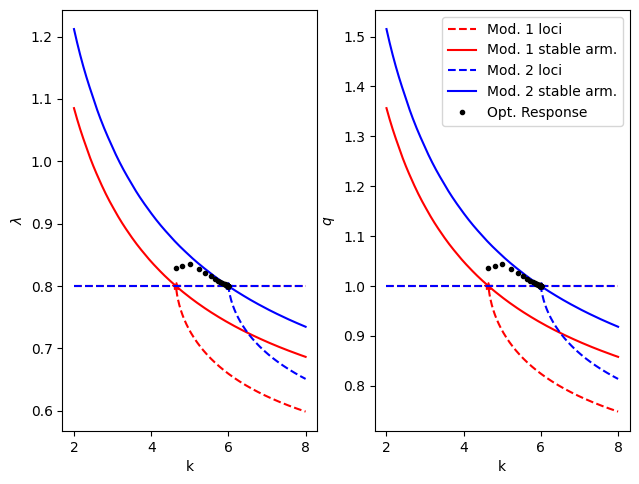

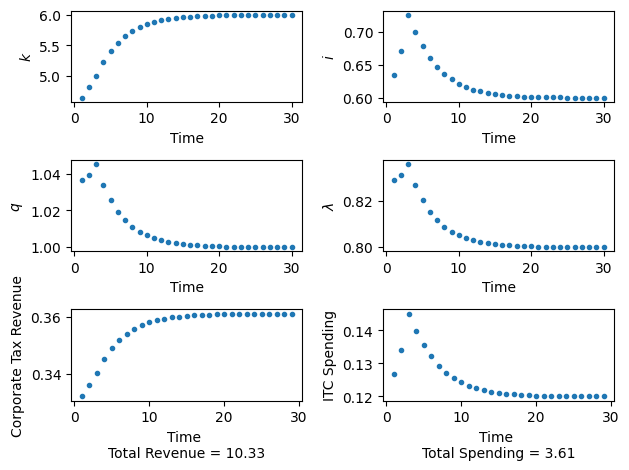

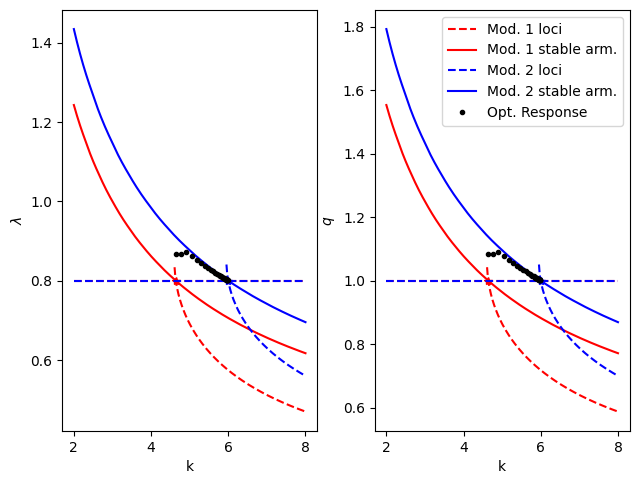

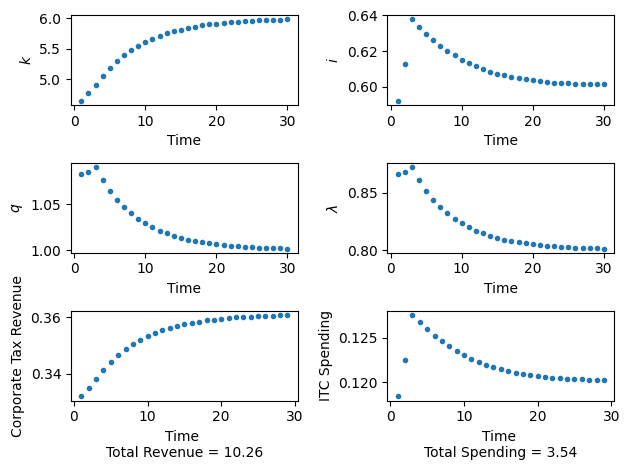

In [36]:
# Here a permanent shock to the corporate tax rate (tau) occurs in period 3
shockVar = 'tau'; shockValue   = 0.05; shockSeq = np.array([tau]*3 + [shockValue]*(T-3))

# Create phase diagrams and impulse responses
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDolo,ExogPaths=Exog,T=T,BaseModel=Qmodel)

# Create phase diagrams and impulse responses in high adjustment costs case
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDoloH,ExogPaths=Exog,T=T,BaseModel=QmodelH)

##  New Steady State
Here we have the inverse of the permanent corporate tax increase. The $ITC_t$ is unchanged, so the dynamics of $q$ are given by

$𝔼_t[\Delta ϙ_{t+1}] ≈ (r + δ)ϙ_t - [(1-\tau)f^k_t(k_t) - j^k_tβ]$,

and the $𝔼_t[\Delta ϙ_{t+1}] = 0$ locus is $ϙ_t = [(1-\tau)f^k_t(k_t) - j^k_t\beta]/(r + \delta)$.

Since $f^k_t(k_t) > 0$ for any level of $k_t$, when the corporate tax rate $\tau$ decreases, $ϙ_t$ must be higher. Thus the locus $𝔼_t[\Delta ϙ_{t+1}] = 0$ shifts up.

The $\Delta k_{t+1} = 0$ locus is unaffected, since $\delta$ and  $𝒫_t$ are unchanged. Therefore in the new steady state, $k_t$ increases,$ϙ_t$ returns to its equilibrium value of 1, and since $𝒫_t$ is unchanged, $\lambda$ also returns to its original value before the tax cut.

## Dynamics
Once the tax change is in effect, the firm's after-tax marginal product of capital $(1-\tau)f^k_t(k_t)$ will be higher, so $𝔼_t[\Delta ϙ_{t+1}] < 0$ and will receive net investment. However, since the tax cut is anticipated, the firm has an opportunity to spread the quadratic adjustment costs over the periods $t$ to $t + 3$. Thus it will increase its capital to take advantage of the future after-tax marginal productivity boost. Thus investment increases, $ϙ_t$ and therefore $\lambda$ increase, and capital increases somewhat. Then after period $t+3$, the firm will follow the stable arm to the new steady state.


# Problem 4

4. Do your results have any implications for whether, when lawmakers introduce a bill to increase the corporate tax rate, they will want to make it ‘retroactive’ (that is, if the τ change ever passes, it would apply to profits made during the period between the introduction of the bill and its passage into law). Is this the same as or different from the implications for the ITC?

Once a bill has been introduced, there are four key factors that may influence the firm's behavior: 
1. Corporate Tax or ITC.
2. Firms beleifs about passage of the bill
3. Realized passage of the bill
4. Retroactive policy

Different combinations of these factors will steer the dynamics into different scenarios we've studied so far. 

## Corporate Tax Change

First, let's supplement figures from problems 1 and 2 with an anticipated tax increase in period three.

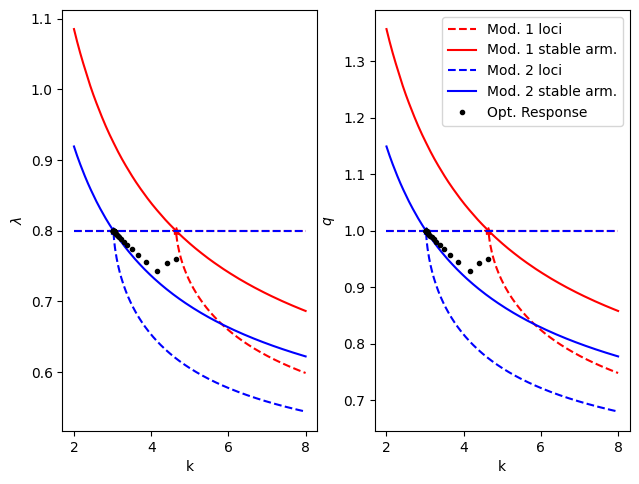

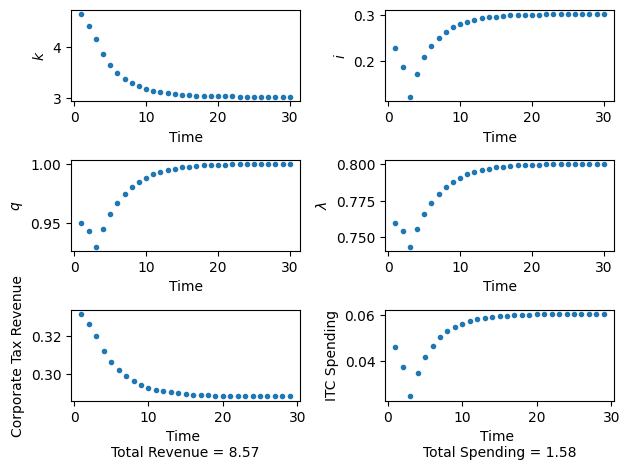

In [37]:
# Here a permanent shock to the corporate tax rate (tau) occurs in period 3
shockVar = 'tau'; shockValue   = 0.4; shockSeq = np.array([tau]*3 + [shockValue]*(T-3))

# Create phase diagrams and impulse responses
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDolo,ExogPaths=Exog,T=T,BaseModel=Qmodel)

### Firms Behavior across cases

Suppose that once a bill is introduced, firms believe that it will be passed, and the policy is not retroactive. Then if a corporate tax increase is proposed, the firms will treat it as an anticipated change in tau, and will behave inversely to the dynamics seen in question three: they will decrease their investment even before the bill is passed in order to minimize the convex adjustment costs. If the bill is not passed, however, they will return to their previous behavior, somewhat similarly to the unanticipated but temporary tax increase situation in question two. 

Now suppose policy is retroactive, and firms continue to believe it will be passed. Then as soon as the policy is proposed, the firms should behave as though the policy is currently in effect, i.e. as if there has been an unanticipated increase in the corporate tax rate. Thus firms will immediately react as in the scenario in question one. However, if the bill is not passed, then the dynamics will be exactly like question two, but the firms will have a temporary period of positive profits, since the taxes were never realized.

Consider the case where firms are more skeptical about the passage of the bill--for simplicity, assume they think there is no chance the policy will go into effect. In this situation, regardless of if the policy is retroactive or not, the firms will treat the policy as unanciticpated once it is passed. Thus we will be in the world of question one. 

### Budget Implications

For each policy, the firth and sixth panels of impulse responses show the tax revenue and ITC spending in the periods around the policy change, and their totals across the T = 30 periods. These calculations are, of course, specific to the chosen calibration of the model. Notice that with the unanticipated tax increase (which is guarunteed by a retroactive policy), the government nets a surplus of $8.54 - 1.56 = 6.98$, and with the anticipated tax increase, the government surplus is $8.57 - 1.58 = 6.99$. With these parameters and low adjustment costs, this is a negligible difference. 

Thus, since the economy will reach its new steady state regardless of the short run dynamics, and government budget implications are the same, the only real difference between a retroactive policy and a non-retroactive policy is that if firms believe the policy will pass, but it does not, the retroactive policy will induce a larger deviation from the economy's current steady state if the bill is meant to be retroactive. Thus, lawmakers would likely prefer to use a non-retroactive corporate tax increase. 

### Political Argument 

Also, somewhat cynically, if a lawmaker's objective is simply to stay elected in the short run, a delay of the largest decrease in investment for 2-3 years into the future aligns with their politcal incentives. Thus the retroactive policy is certainly not preferred. 

## Comparison to ITC

Below are three new sets of figures containing an ITC decrease--a restricitive policy, similarly to a corporate tax increase. The first set of figures show the dynamics if the policy is unanticipated, the second shows if it is anticipated by three periods, the third is if the policy is unanticipated and temporary.

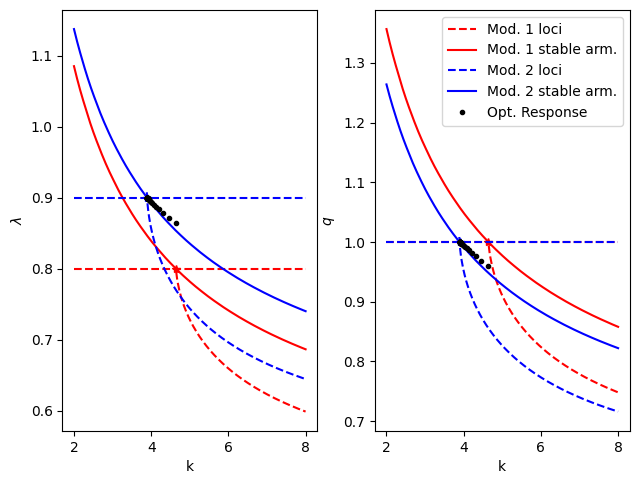

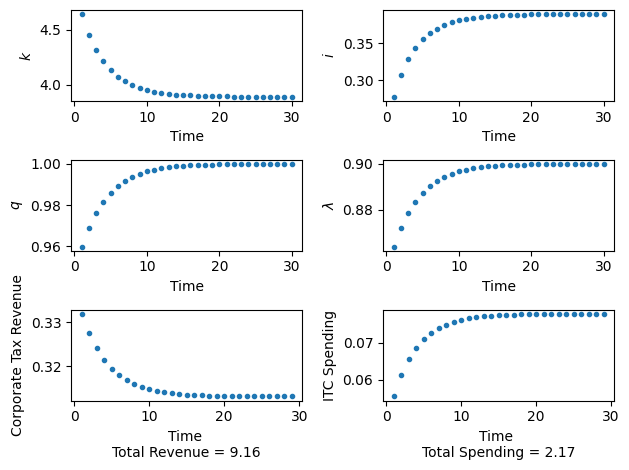

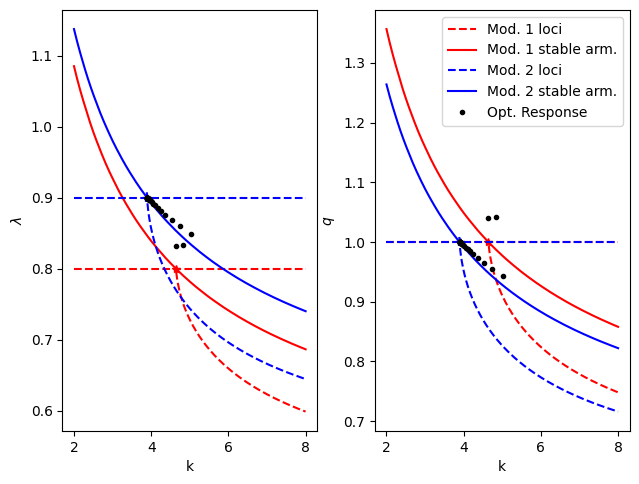

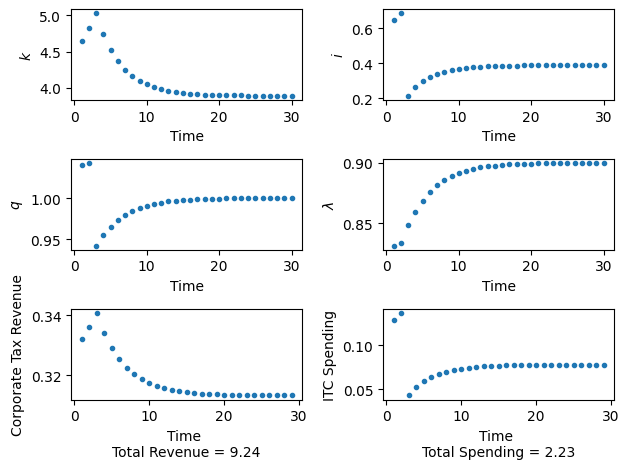

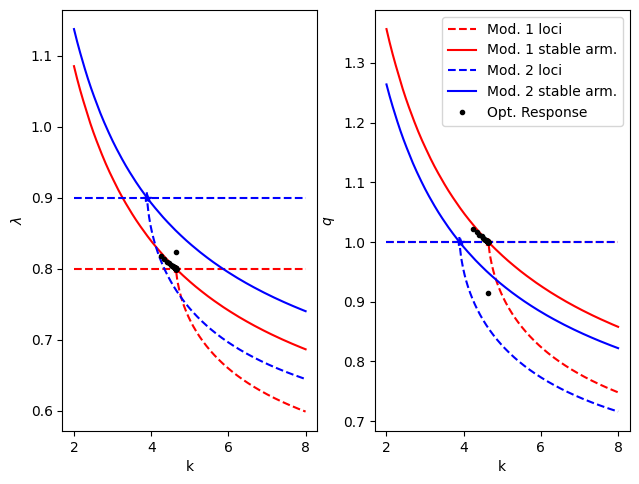

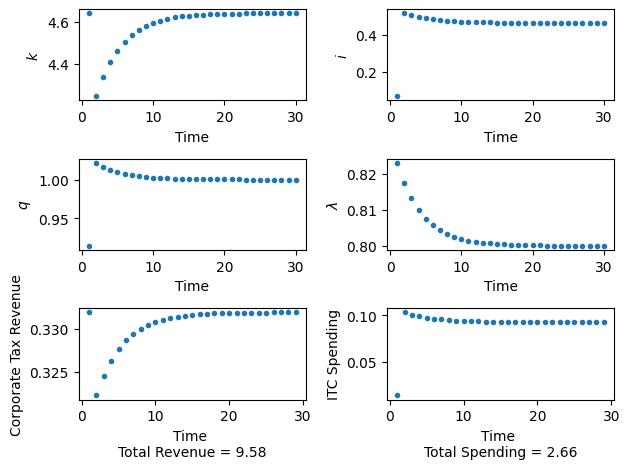

In [42]:
# Here a permanent shock to the ITC occurs in period 0
shockVar = 'itc_1'; shockValue   = 0.1; shockSeq = np.array([shockValue]*(T))

# Create phase diagrams and impulse responses
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDolo,ExogPaths=Exog,T=T,BaseModel=Qmodel)

# Here a permanent shock to the ITC occurs in period 3
shockVar = 'itc_1'; shockValue   = 0.1; shockSeq = np.array([zeta]*3 + [shockValue]*(T-3))

# Create phase diagrams and impulse responses
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDolo,ExogPaths=Exog,T=T,BaseModel=Qmodel)

# Here a temporary shock to the ITC occurs in period 0
shockVar = 'itc_1'; shockValue   = 0.1; shockSeq = np.array([shockValue]*(2) + [zeta]*(T-2))

# Create phase diagrams and impulse responses
run_counterfactual(shockSeq=shockSeq, shockValue=shockValue, shockVar=shockVar,QDolo=QDolo,ExogPaths=Exog,T=T,BaseModel=Qmodel)

### Firms Behavior across cases

The various scenarios play out similarly with an ITC as they do with a coporate tax increase: 

If firms believe that a policy will be passed, and the policy is not retroactive, firms will treat it as an anticipated change in zeta. Thus, they will decrease their investment even before the bill is passed. If the bill is not passed, however, they will return to their previous behavior.

If policy is retroactive, and firms believe it will be passed, then as soon as the policy is proposed, the firms behave as though there was an unanticipated shock in the ITC before it is even passed. However, if the bill is not passed it will act as a temporary change in the ITC. 

If the firms don't believe it will pass, then whether it is retroactive or not is irrelevant to the firm's behavior. 

### Budget Implications

Just as the experiment changing tau, the net budget for the government is essentially the same between the unanticipated and anticipated shocks: $6.99$ and $7.01$, respectively. Thus the analysis is broadly the same as before: the lawmakers prefer the non-retroactive policy.

### Political Argument

Note for the ITC, the short run behavior of the firm in the anticipated scenario is to not just decrease investment less, but actually INCREASE investment to take advantage of the few years of high tax credits. Thus the lawmaker's political incentives are to avoid an unanticipated shock, and implement a non-retroactive policy. 

# Problem 5

5. How would your results to the previous question change if corporations had some accounting tricks they could use, at a smoothly convex increasing cost, to shift “reported” profits between calendar years? (By smoothly convex increasing costs, we mean costs like those for investment in the q model; that is, the marginal cost to move a negligible amount ϵ of reported taxes between t and t + 1, is tiny (proportional to ϵ2). (You do not need to make diagrams or do quantitative analysis for this question; intuition is enough).

With relatively low costs to shift reported profits, firms will move a large portion of their profits into the time period during which the tax burden is lowest (or credits the highest). Thus the arguments for the previous question will simply be amplified--the government's budget will be largely unaffected, but short run investment will be better off if the policy is anticipated, and will therefore be preferred by the lawmakers. If the costs of shifting reported profits are high, this behavior will happen less frequently, but the conclusion is the same as in question 4.  